In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
import tensorflow as tf
import talib
from tensorflow import keras
from sklearn.pipeline import make_pipeline
from tensorflow.keras import regularizers

2022-04-09 00:38:08.233740: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 00:38:08.233786: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
data=yf.download('0005.hk')

[*********************100%***********************]  1 of 1 completed


In [5]:
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=10,forward=True,verbose=2,cv=5,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())

/tmp/ipykernel_24631/3806124569.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  backwardModel.fit(np.array(data.drop('Prediction',1)),data['Prediction'].values.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  19 | elapsed:    9.4s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  12 out of  19 | elapsed:   10.4s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   11.8s finished

[2022-04-09 00:38:44] Features: 1/10 -- score: 0.8003921062435488[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:    5.6s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.0s finished

[2022-04-09 00:38:50] Features: 2/10 -- score: 0.7962204215929313[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=10,
                          n_jobs=-1, scoring='r2', verbose=2)

In [7]:
data=data[data.columns[list(backwardModel.k_feature_idx_)]]
data['Prediction']=data['Close'].shift(-1)
data.dropna(inplace=True)
data_val=data[-100:]
data=data[:-100]
data_val.tail()

/tmp/ipykernel_24631/1273356578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Prediction']=data['Close'].shift(-1)
/tmp/ipykernel_24631/1273356578.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


,Low,Close,Volume,RSI,%R5,%R10,MI6,TR,OSC6,OSC12,Prediction
Date,,,,,,,,,,,
2022-03-30,53.750000,53.950001,20820331,69.919360,-20.833320,-10.638296,1.600002,0.950001,46.622377,18.475039,54.200001
2022-03-31,53.799999,54.200001,12951991,71.849555,-14.285714,-6.849312,1.049999,0.500000,50.893767,20.961286,54.349998
2022-04-01,53.400002,54.349998,8177523,73.059622,-6.060739,-2.777840,1.649998,0.949997,53.568896,22.508117,54.049999
2022-04-04,53.799999,54.049999,10779509,66.399654,-24.242494,-12.903266,1.250000,0.549999,35.812143,17.491249,53.700001
2022-04-06,53.150002,53.700001,17097274,59.070435,-57.692342,-31.249980,-0.049999,0.899998,16.890204,11.670984,53.450001


In [8]:
sc = MinMaxScaler(feature_range = (-1, 1))

In [9]:
X=sc.fit_transform(data.drop('Prediction',1))
Y = data["Prediction"].values.reshape(-1,1)
# Y=np.array(data["Close"])
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(4889, 1, 10) (4889, 1) (544, 1, 10) (544, 1)


/tmp/ipykernel_24631/2420511516.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X=sc.fit_transform(data.drop('Prediction',1))


In [10]:
model_tech = keras.Sequential()
model_tech.add(keras.layers.LSTM(
  units=128,
  input_shape=(X_train.shape[1], X_train.shape[2]),
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01)
))
model_tech.add(keras.layers.LSTM(units=64))
model_tech.add(keras.layers.Dense(units=64))
model_tech.add(keras.layers.Dense(units=1))
model_tech.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

2022-04-09 00:39:57.175037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-09 00:39:57.175304: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-09 00:39:57.175344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-09 00:39:57.175393: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-09 00:39:57.175447: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [11]:
history_tech=model_tech.fit(
    X_train, y_train,
    epochs=300,
    batch_size=5,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)
y_pred = model_tech.predict(X_test)

Epoch 1/300
880/880 [==============================] - 5s 3ms/step - loss: 645.0750 - val_loss: 15.0153
Epoch 2/300
880/880 [==============================] - 3s 3ms/step - loss: 10.4439 - val_loss: 8.1735
Epoch 3/300
880/880 [==============================] - 2s 3ms/step - loss: 6.3545 - val_loss: 5.0272
Epoch 4/300
880/880 [==============================] - 3s 3ms/step - loss: 4.2882 - val_loss: 3.3897
Epoch 5/300
880/880 [==============================] - 3s 3ms/step - loss: 3.3440 - val_loss: 2.7456
Epoch 6/300
880/880 [==============================] - 3s 3ms/step - loss: 2.9974 - val_loss: 2.5058
Epoch 7/300
880/880 [==============================] - 3s 3ms/step - loss: 2.8543 - val_loss: 2.3675
Epoch 8/300
880/880 [==============================] - 3s 3ms/step - loss: 2.7776 - val_loss: 2.2821
Epoch 9/300
880/880 [==============================] - 3s 3ms/step - loss: 2.7252 - val_loss: 2.2228
Epoch 10/300
880/880 [==============================] - 3s 3ms/step - loss: 2.6840 - va

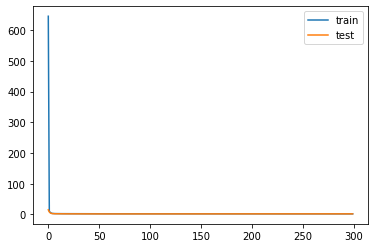

In [12]:
plt.plot(history_tech.history['loss'], label='train')
plt.plot(history_tech.history['val_loss'], label='test')
plt.legend()

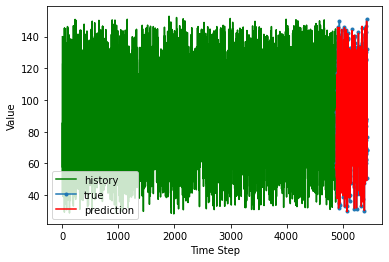

In [13]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

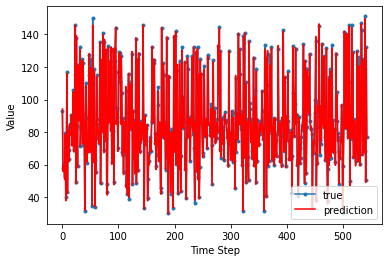

In [14]:
# y_test = sc.inverse_transform(y_test)
# y_pred = sc.inverse_transform(y_pred)
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [15]:
r2_score(y_test,y_pred)

0.9975220619203751

In [16]:
mean_absolute_percentage_error(y_test,y_pred)

0.013136572595133586

In [17]:
mean_squared_error(y_test,y_pred,squared=False)

1.3521231912825105

In [18]:
x_val=data_val.drop('Prediction',1)
y_val=data_val['Prediction']
x_val=sc.transform(x_val).reshape(x_val.shape[0],1,x_val.shape[1])
y_val_pred=model_tech.predict(x_val)

/tmp/ipykernel_24631/2328949661.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_val=data_val.drop('Prediction',1)


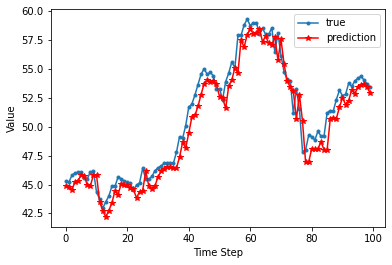

In [19]:
plt.plot(y_val.values, marker='.', label="true")
plt.plot(y_val_pred, 'r', marker='*',label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [20]:
r2_score(y_val,y_val_pred)

0.9329305879725057

In [21]:
mean_absolute_percentage_error(y_val,y_val_pred)

0.019605437840153627

In [22]:
mean_squared_error(y_val.values,y_val_pred,squared=False)

1.2225490482114043